# A Comprehension of Intelligent Document Processing

### SROIEv2: The Receipts Dataset

In [106]:
!pip install pytesseract pillow

In [111]:
import kagglehub
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os
import time
from PIL import Image
import pytesseract
from google import genai
from google.colab import userdata
import json

#### Getting data

In [70]:
# Download lastest version
path = kagglehub.dataset_download("urbikn/sroie-datasetv2")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'sroie-datasetv2' dataset.
Path to dataset files: /kaggle/input/sroie-datasetv2


#### No document classification needed for this dataset, all documents are receipts!

In [ ]:
! cat /root/.cache/kagglehub/datasets/urbikn/sroie-datasetv2/versions/4/SROIE2019/test/entities/X00016469670.txt

{
    "company": "OJC MARKETING SDN BHD",
    "date": "15/01/2019",
    "address": "NO 2 & 4, JALAN BAYU 4, BANDAR SERI ALAM, B1750 MASAI, JOHOR",
    "total": "193.00"
}

### Image Preprocessing: OpenCV

In [72]:
one_image_path = os.path.join(path, "SROIE2019", 'train', "img", "X51005453729.jpg" )

In [73]:
def display_image(image, title='Image'):
    plt.figure(figsize=(7, 7))
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

 - Looking at one training image.

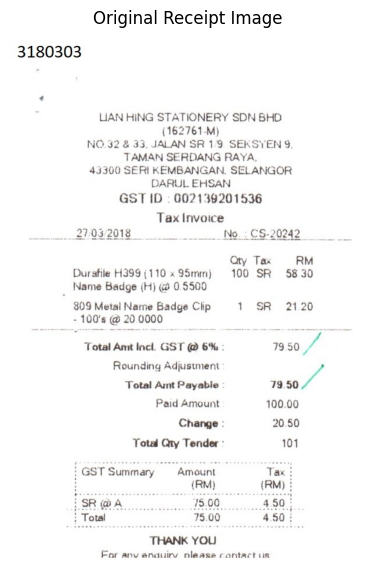

In [74]:
one_image = cv.imread(one_image_path)
display_image(one_image, "Original Receipt Image")

### Grayscale Conversion

 - Color information is usually not necessary for reading the text on a receipt. Converting the image to grayscale simplifies it from three color channels (Red, Green, Blue) to a single channel (intensity/brightness)

In [75]:
def convert_to_grayscale(image):
  return cv.cvtColor(image, cv.COLOR_BGR2GRAY)

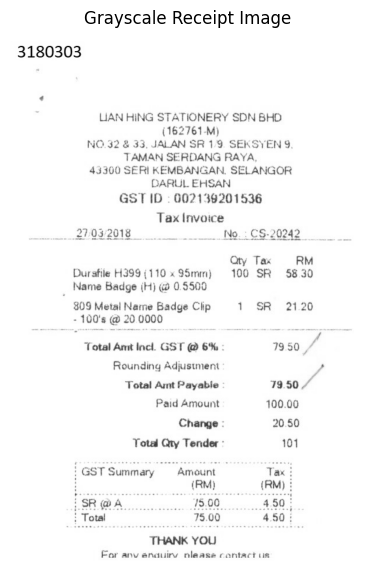

In [76]:
grayscale_image = convert_to_grayscale(one_image)
display_image(grayscale_image, "Grayscale Receipt Image")

In [77]:
# 3 channels   vs  1 channel
one_image.shape, grayscale_image.shape

((931, 615, 3), (931, 615))

### Noise (blur) Reduction
 - Scanned images or photos often contain "noise" (random variations in brightness or color). This can look like small specks or graininess, which can confuse OCR algorithms. Applying a slight blur helps to smooth out this noise. A **Gaussian blur** effectively averages out pixel values with a weighted average, preserving edges better than a simple blur.

In [ ]:
def reduce_noise(grayscale_image):
    return cv.GaussianBlur(grayscale_image, (5, 5), 0)

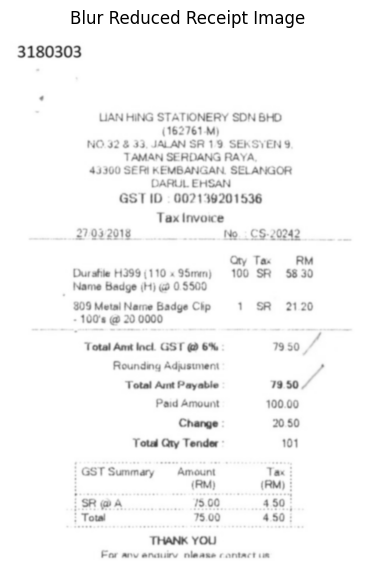

In [79]:
blur_reduced_image = reduce_noise(grayscale_image)
display_image(blur_reduced_image, "Blur Reduced Receipt Image")

### Binarization (Thresholding)

 - Binarization converts the grayscale image into a pure black-and-white image. The goal is to make the text **black** and the background **white**. However, receipts often have uneven lighting or shadows, so a simple (global) threshold won't work well. I`m using **adaptive thresholding**, which calculates a different threshold for smaller regions of the image, making it robust to lighting changes.

In [ ]:
def binarize_image(blur_reduced_image):
  return cv.adaptiveThreshold(
    blur_reduced_image,
    255,
    cv.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv.THRESH_BINARY,
    11,
    4
  )

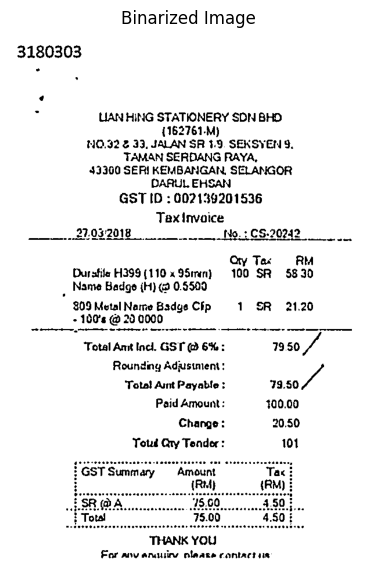

In [97]:
binarized_image = binarize_image(blur_reduced_image)
display_image(binarized_image, "Binarized Image")

### Skew Correction

 - Receipts are often scanned or photographed at a slight angle. This skew can significantly reduce the accuracy of OCR. We need to detect this angle and rotate the image to make the text perfectly horizontal.

 - A common technique is to find the angle of the minimum-area bounding box that encloses all the text (the white pixels in our binarized image) and then rotate the original image by that angle.



In [ ]:
def deskew_image(image):
    """
    Corrects the skew of an image by finding the minimum area rectangle
    of the text block and rotating accordingly.
    """
    # Find all non-zero (white) pixels
    coords = cv.findNonZero(image)

    # Get the minimum area bounding rectangle
    # It returns (center(x,y), (width, height), angle of rotation)
    rect = cv.minAreaRect(coords)
    angle = rect[-1] - 90

    # The `cv2.minAreaRect` angle has a specific range.
    # We need to adjust it for our rotation.
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = angle

    # Get the rotation matrix and rotate the image
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv.warpAffine(image, M, (w, h),
                             flags=cv.INTER_CUBIC,
                             borderMode=cv.BORDER_REPLICATE)
    print(f"Detected skew angle: {angle:.2f} degrees")

    # Rotate the original grayscale image by the same angle
    (h, w) = rotated.shape
    center = (w // 2, h // 2)
    M = cv.getRotationMatrix2D(center, angle, 1.0)
    deskewed_gray = cv.warpAffine(rotated, M, (w, h),
                                  flags=cv.INTER_CUBIC,
                                  borderMode=cv.BORDER_REPLICATE)

    return deskewed_gray

In [ ]:
deskewed_image = deskew_image(binarized_image)

Detected skew angle: -0.00 degrees


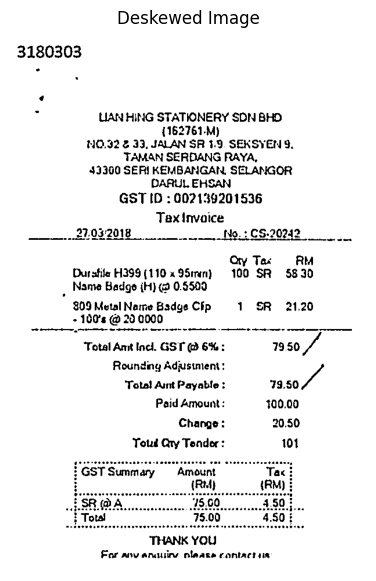

In [101]:
display_image(deskewed_image, "Deskewed Image")

Run the above code for all images

In [102]:
def process_one_image(image):
  image = convert_to_grayscale(image)
  print("Converted image to grayscale..")
  image = reduce_noise(image)
  print("Reduced noise in the image..")
  image = binarize_image(image)
  print("Binarized the image..")
  image = deskew_image(image)
  print("Corrected image orientation..")
  return image

 - Processing just 20 images because i'm going to use Gemini for LLM and the free version is limited, also it will take more than 15 hours to train on all images

In [ ]:
output_folder_path = "/content/processed_images"
start_time = time.time()

if os.makedirs(output_folder_path, exist_ok=True):
  print(f"Created folder: {output_folder_path}")

for image_name in os.listdir(os.path.join(path, 'SROIE2019', 'train', 'img'))[:20]:
  print(f"Processing image: {image_name}")
  image_path = os.path.join(path, 'SROIE2019', 'train', 'img', image_name)
  image = cv.imread(image_path)
  processed_image = process_one_image(image)
  # save image
  output_path = os.path.join(output_folder_path, image_name)
  cv.imwrite(output_path, processed_image)
  print(f"Saved processed image to: {output_path}")
  print("-"*50)

print("Processing images is completed.")
print(f"Total time taken: {time.time() - start_time} seconds")

Processing image: X51007231344.jpg
Converted image to grayscale..
Reduced noise in the image..
Binarized the image..
Detected skew angle: 0.00 degrees
Corrected image orientation..
Saved processed image to: /content/processed_images/X51007231344.jpg
--------------------------------------------------
Processing image: X51005442344.jpg
Converted image to grayscale..
Reduced noise in the image..
Binarized the image..
Detected skew angle: 0.00 degrees
Corrected image orientation..
Saved processed image to: /content/processed_images/X51005442344.jpg
--------------------------------------------------
Processing image: X51008142030.jpg
Converted image to grayscale..
Reduced noise in the image..
Binarized the image..
Detected skew angle: 0.00 degrees
Corrected image orientation..
Saved processed image to: /content/processed_images/X51008142030.jpg
--------------------------------------------------
Processing image: X51005447853.jpg
Converted image to grayscale..
Reduced noise in the image..
Bi

## Text Extraction: Tesseract
 - the Tesseract with default hyperparamethers.

In [108]:
pytesseract.image_to_string(Image.open('/content/processed_images/X51006414392.jpg'))

'DI HUAN YA RESTAURANT\nGampany Reg.No: JM0681589-VV¥\n5, JALAN FERMAS 104,\nBANDAR BARU PERMAS JAYA,\n81750 JOHOR BAHRU JOHOR\nTEL/FAX07-3886322\n[GST ID : 001914083568 J\n\nTAX INVOICE , ‘on |\nInvNo: 199977 | _ rls\n\nCashier: c001- .\n\nDate : 07/04/2018 - 18.10:59\n\nQty Description ea, Potal (RM) Tax\n1 106... 33.00 SR\n\nHTAKE AWAY!\nROASTED DUCK WITH CHINESE\nHERB (HALF)\n\nTotalSales Amount = = = = =———is—<—~s~*s«SS_HOD\nGST 6% 1.98\nRounding Adjustmerit 0.02\nTOTAL 8500\nCASH | OC 55.00\nChange Returned 20.00-\n\nltem Gount: 1\n\nGST Summary Amount (RM) Tax (RM)\n\nSR = 6% 33.90 1.98\n\nThank ‘You!\nPlease Come Again\nGoods Sold Aré Not Returnabla!\nClosed by - c001- 0) 7/04/2018-13:11:05\n\nw= [| FOSWAY - MYTH POS SOLUTION J ---\n\x0c'

In [ ]:
input_folder_path = "/content/processed_images"
output_folder_path = "/content/tesseract_output"
start_time = time.time()

if os.makedirs(output_folder_path, exist_ok=True):
  print(f"Created folder: {output_folder_path}")

total_images = sum(1 for entry in os.scandir(input_folder_path))
print(f"Total images in folder: {total_images}")

for i, image_name in enumerate(os.listdir(input_folder_path)[:20], 1):
  print(f"Processing image {i}/{total_images}: {image_name}")
  image_path = os.path.join(input_folder_path, image_name)
  print("Extracting text from image..")
  text = pytesseract.image_to_string(Image.open(image_path))
  output_path = os.path.join(output_folder_path, image_name.replace(".jpg", ".txt"))
  with open(output_path, "w") as f:
    f.write(text)

  print(f"Saved extracted text to {output_path}")
  print("-"*50)

print("Text Extraction Completed.")
print(f"Total time taken: {time.time() - start_time} seconds")

Total images in folder: 20
Processing image 1/20: X51005441408.jpg
Extracting text from image..
Saved extracted text to /content/tesseract_output/X51005441408.txt
--------------------------------------------------
Processing image 2/20: X51006620189.jpg
Extracting text from image..
Saved extracted text to /content/tesseract_output/X51006620189.txt
--------------------------------------------------
Processing image 3/20: X51008142030.jpg
Extracting text from image..
Saved extracted text to /content/tesseract_output/X51008142030.txt
--------------------------------------------------
Processing image 4/20: X51007419197.jpg
Extracting text from image..
Saved extracted text to /content/tesseract_output/X51007419197.txt
--------------------------------------------------
Processing image 5/20: X51008099044.jpg
Extracting text from image..
Saved extracted text to /content/tesseract_output/X51008099044.txt
--------------------------------------------------
Processing image 6/20: X51005442344.jp

## Information Extraction

In [110]:
prompt = """
Extract the information from the given image.
Information to be extracted: company, date, address, total.
The image has been converted to grayscale, noise reduced, binarized, and deskewed using opencv.
Always give your response in the following format:
{
    "company": "COMPANY_NAME",
    "date": "DATE",
    "address": "ADDRESS",
    "total": "TOTAL",
}
Also, the text has been extracted from the image using tesseract.
Use the extracted text as support for extracting information.
If you believe the text extraction is incorrect somewhere, you may correct it yourself and provide corrected information.
Respond with the extracted information only in the specified format.
Here is the text:


"""

In [115]:
genai_client = genai.Client(api_key=userdata.get('GOOGLE_API_KEY'))

In [ ]:
image_folder_path = "/content/processed_images"
text_folder_path = "/content/tesseract_output"
output_folder_path = "/content/json_output"

start_time = time.time()

if os.makedirs(output_folder_path, exist_ok=True):
  print(f"Created folder: {output_folder_path}")

total_images = sum(1 for entry in os.scandir(image_folder_path))
print(f"Total images in folder: {total_images}")

for i, image_name in enumerate(os.listdir(input_folder_path)[:20], 1):
  print(f"Processing image {i}/{total_images}: {image_name}")
  image_path = os.path.join(input_folder_path, image_name)
  print(f"Loading image: {image_path}")
  with open(image_path, "rb") as f:
    image = Image.open(image_path)
    # print(image)


  text_path = os.path.join(text_folder_path, image_name.replace(".jpg", ".txt"))
  print(f"Loading extracted text: {text_path}")
  with open(text_path, "r") as f:
    text = f.read()

  print("Extracting information from image and text..")

  prompt = prompt + text



  contents = [
        image,
        {
            "text": prompt
        }
    ]
  response = genai_client.models.generate_content(model='gemini-2.5-flash', contents=contents)

  # Access the usage_metadata attribute
  usage_metadata = response.usage_metadata

  # Print the different token counts
  print(f"Input Token Count: {usage_metadata.prompt_token_count}")
  print(f"Thoughts Token Count: {response.usage_metadata.thoughts_token_count}")
  print(f"Output Token Count: {usage_metadata.candidates_token_count}")
  print(f"Total Token Count: {usage_metadata.total_token_count}")

  extracted_information = json.loads(response.text.replace('```json', '').replace('```', ''))
  output_path = os.path.join(output_folder_path, image_name.replace(".jpg", ".json"))
  with open(output_path, "w") as f:
    json.dump(extracted_information, f, indent=4)

  print(f"Saved extracted information to {output_path}")
  print("-"*50)
  # passing many promts at once will break the Gemini, so i sleep the process for 60s
  time.sleep(60)


print("Information Extraction Completed.")
print(f"Total time taken: {time.time() - start_time} seconds")

Total images in folder: 20
Processing image 1/20: X51005441408.jpg
Loading image: /content/processed_images/X51005441408.jpg
Loading extracted text: /content/tesseract_output/X51005441408.txt
Extracting information from image and text..
Input Token Count: 976
Thoughts Token Count: 317
Output Token Count: 89
Total Token Count: 1382
Saved extracted information to /content/json_output/X51005441408.json
--------------------------------------------------
Processing image 2/20: X51006620189.jpg
Loading image: /content/processed_images/X51006620189.jpg
Loading extracted text: /content/tesseract_output/X51006620189.txt
Extracting information from image and text..
Input Token Count: 1566
Thoughts Token Count: 266
Output Token Count: 108
Total Token Count: 1940
Saved extracted information to /content/json_output/X51006620189.json
--------------------------------------------------
Processing image 3/20: X51008142030.jpg
Loading image: /content/processed_images/X51008142030.jpg
Loading extracted t

### Results comparison

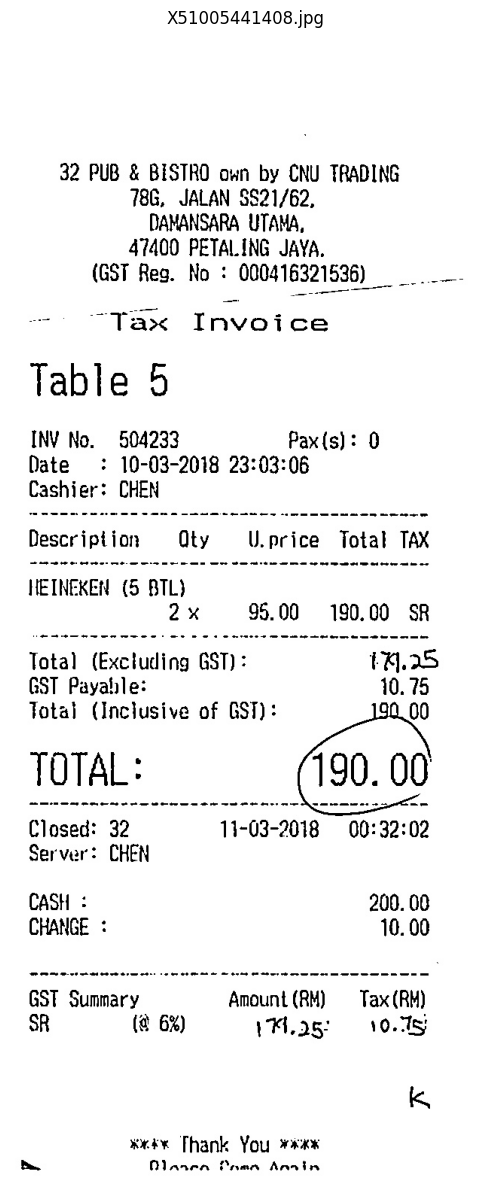

Extracted info for the receipt:
 {'company': '32 PUB & BISTRO', 'date': '10-03-2018', 'address': '78G, JALAN SS21/62, DAMANSARA UTAMA, 47400 PETALING JAYA.', 'total': '190.00'}



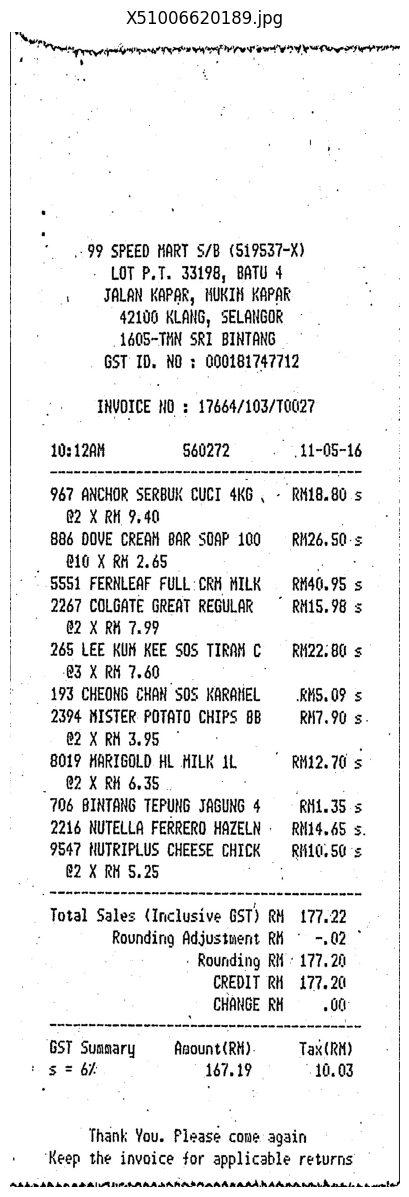

Extracted info for the receipt:
 {'company': '99 SPEED MART S/B', 'date': '11-05-16', 'address': 'LOT P.T. 33198, BATU 4 JALAN KAPAR, MUKIN KAPAR 42100 KLANG, SELANGOR 1605-TMN SRI BINTANG', 'total': '177.22'}



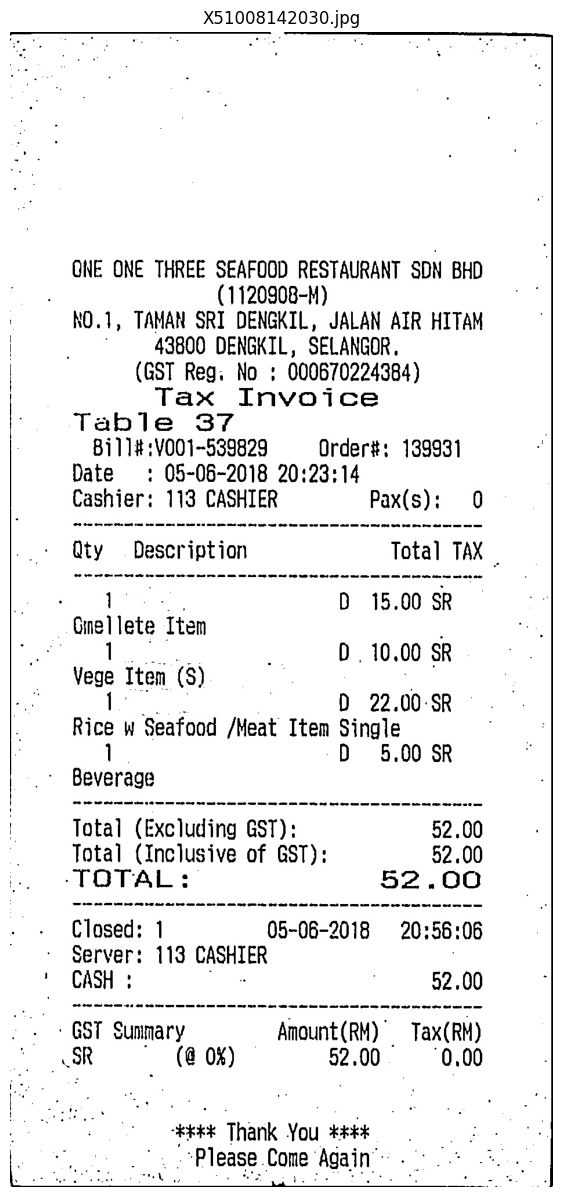

Extracted info for the receipt:
 {'company': 'ONE ONE THREE SEAFOOD RESTAURANT SDN BHD', 'date': '05-06-2018', 'address': 'NO.1, TAMAN SRI DENGKIL, JALAN AIR HITAM 43800 DENGKIL, SELANGOR.', 'total': '52.00'}



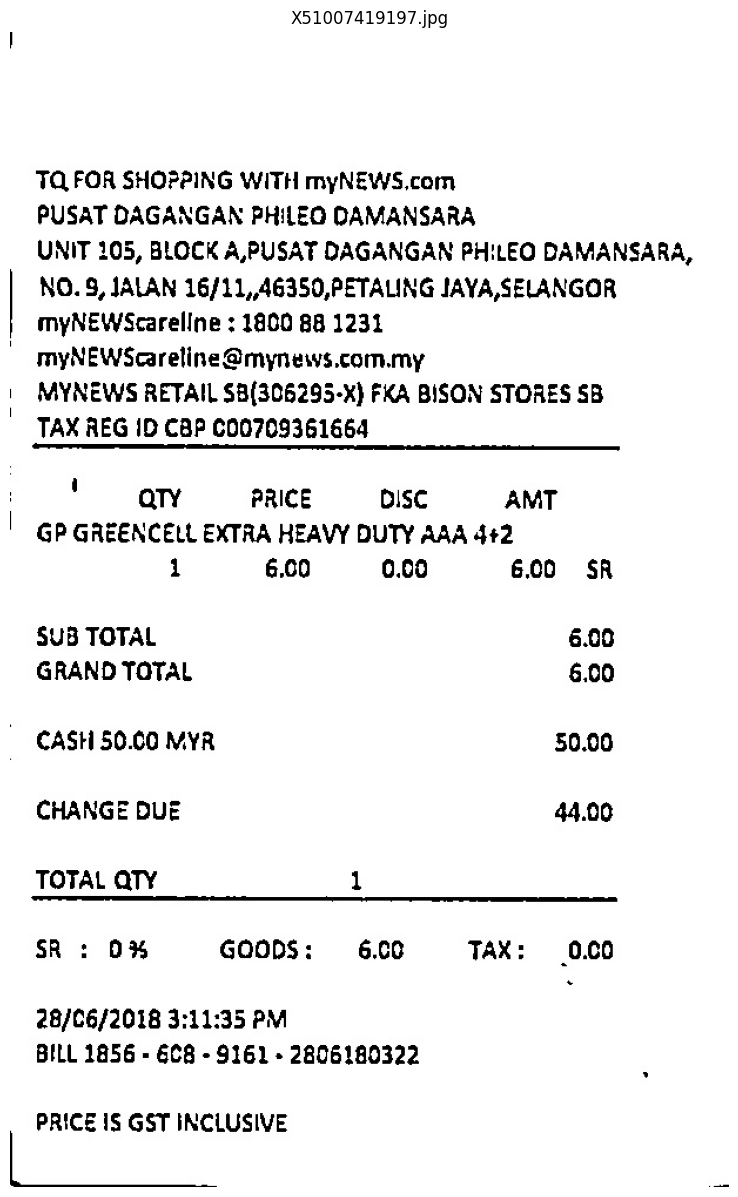

Extracted info for the receipt:
 {'company': 'myNEWS.com', 'date': '28/06/2018', 'address': 'UNIT 105, BLOCK A, PUSAT DAGANGAN PHILEO DAMANSARA, NO. 9, JALAN 16/11, 46350, PETALING JAYA, SELANGOR', 'total': '6.00'}



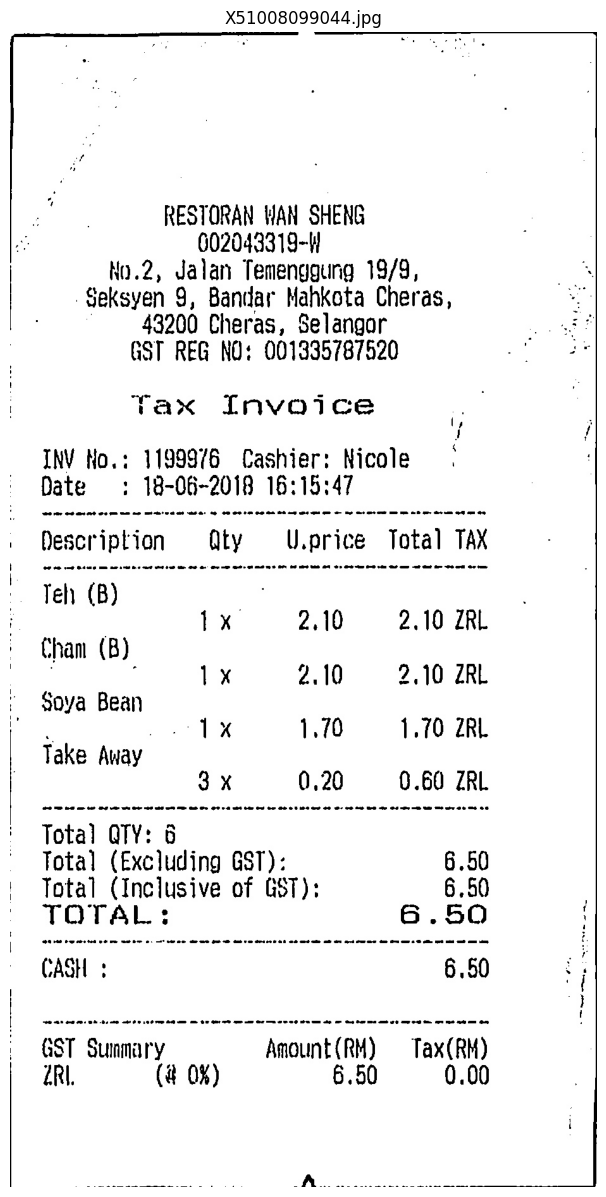

Extracted info for the receipt:
 {'company': 'RESTORAN WAN SHENG', 'date': '18-06-2018', 'address': 'No.2, Jalan Temenggung 19/9, Seksyen 9, Bandar Mahkota Cheras, 43200 Cheras, Selangor', 'total': '6.50'}



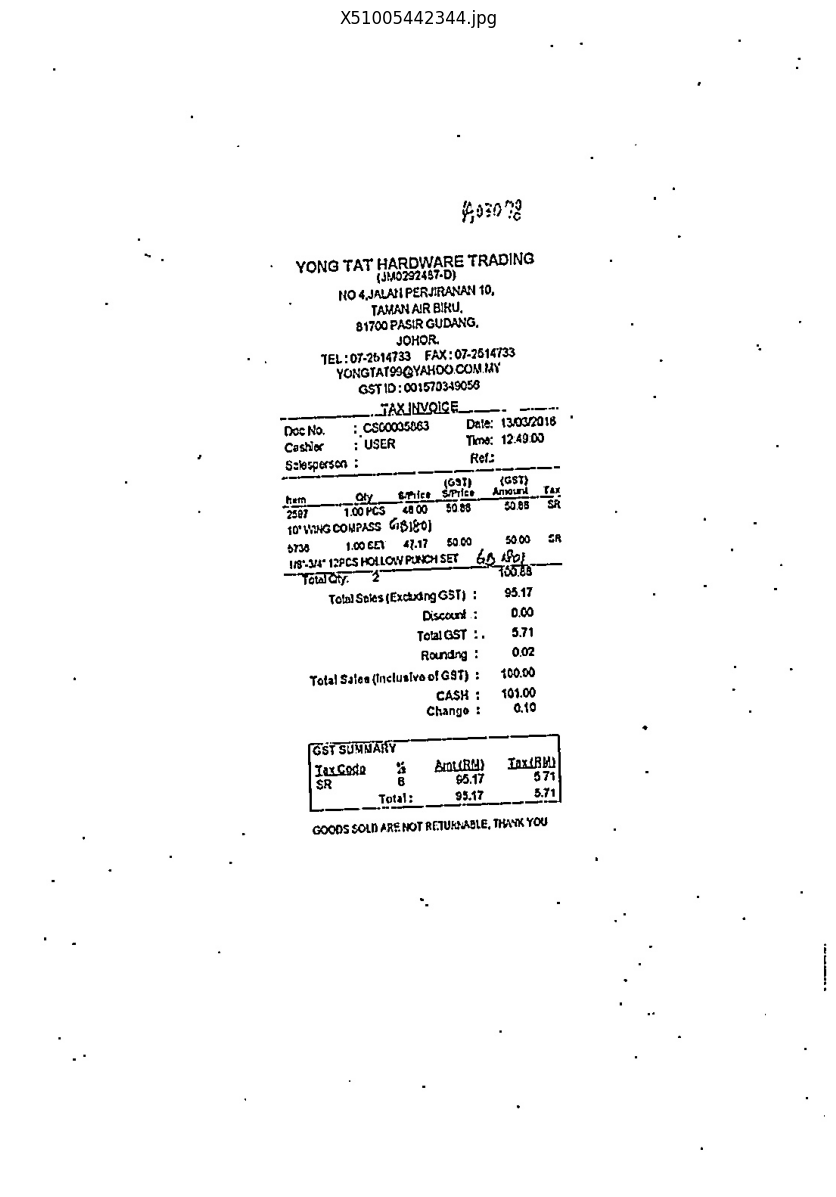

Extracted info for the receipt:
 {'company': 'YONG TAT HARDWARE TRADING', 'date': '13/03/2018', 'address': 'NO 4,JALAH PERJIRANAN 10, TAMAN AIR BIRU, 81700 PASIR GUDANG, JOHOR.', 'total': '100.00'}



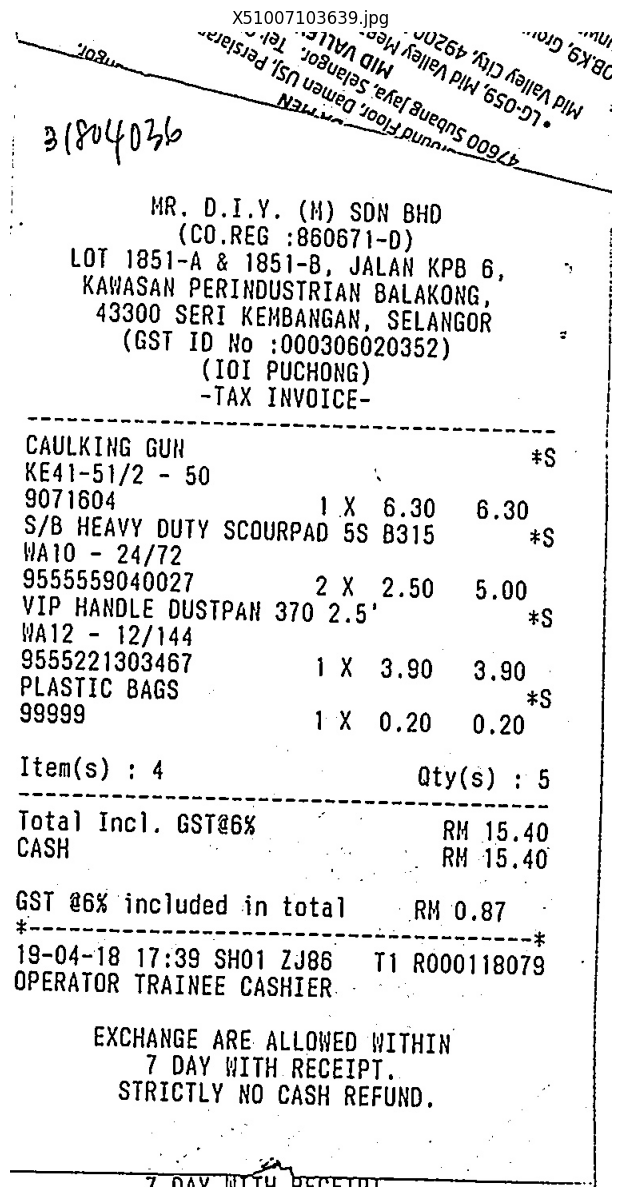

Extracted info for the receipt:
 {'company': 'MR. D.I.Y. (M) SDN BHD', 'date': '19-04-18', 'address': 'LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR', 'total': '15.40'}



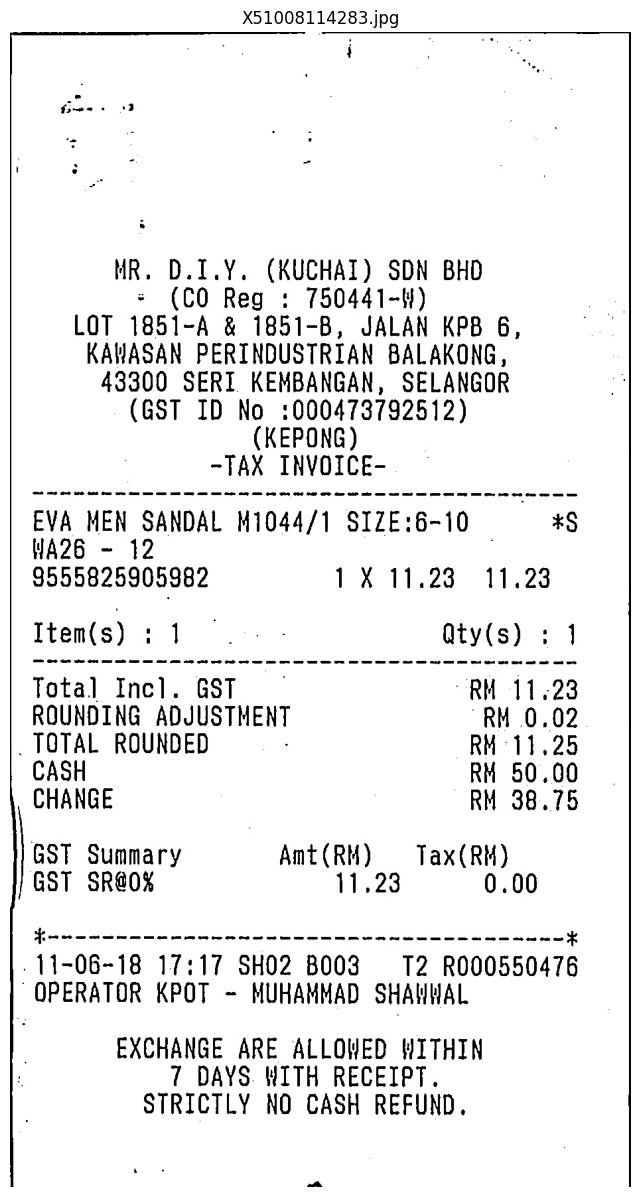

Extracted info for the receipt:
 {'company': 'MR. D.I.Y. (KUCHAI) SDN BHD', 'date': '11-06-2018', 'address': 'LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR (KEPONG)', 'total': '11.25'}



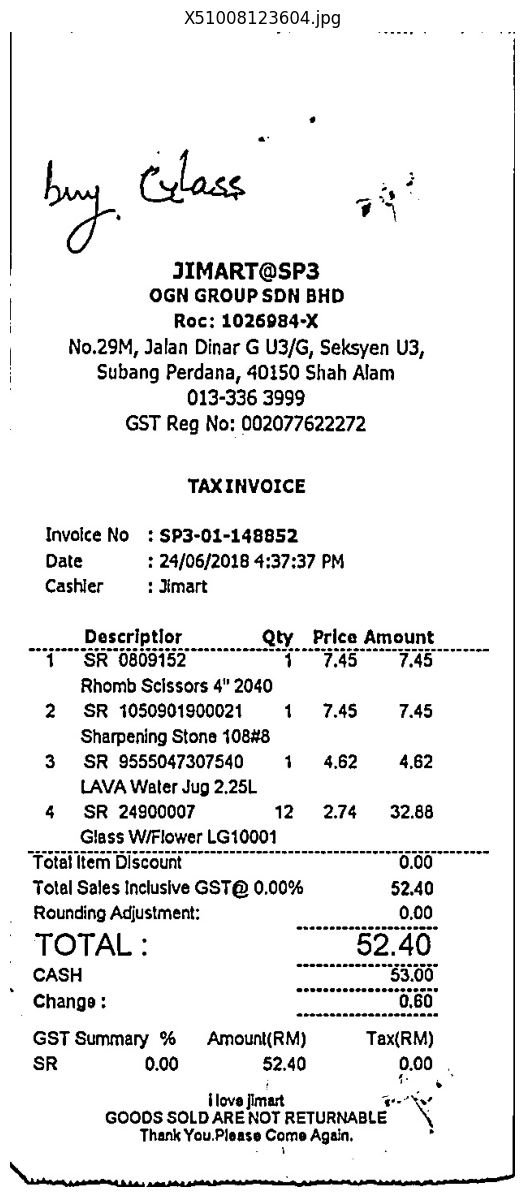

Extracted info for the receipt:
 {'company': 'JIMART@SP3 OGN GROUP SDN BHD', 'date': '24/06/2018', 'address': 'No.29M, Jalan Dinar G U3/G, Seksyen U3, Subang Perdana, 40150 Shah Alam', 'total': '52.40'}



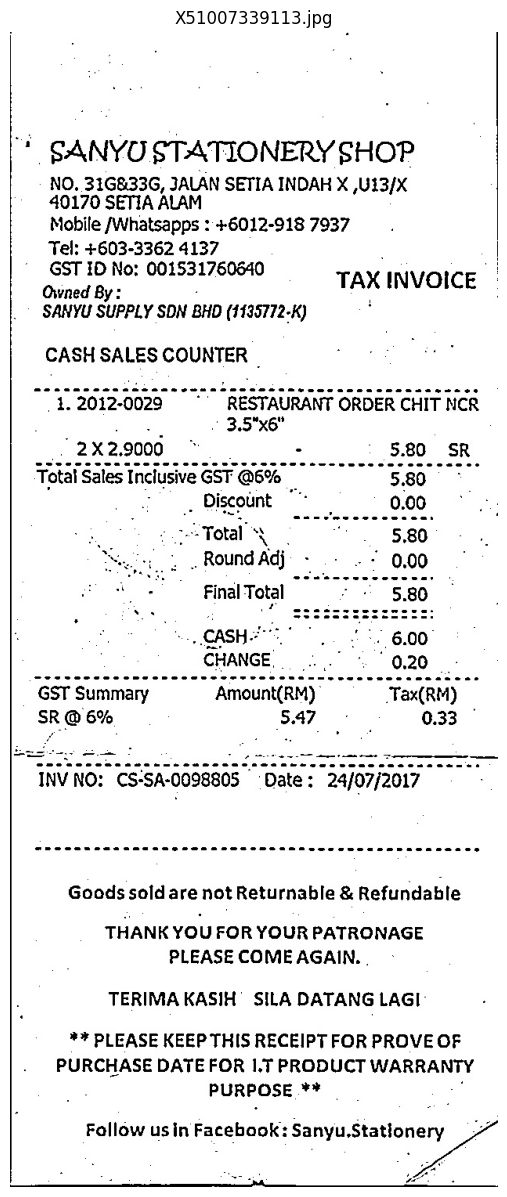

Extracted info for the receipt:
 {'company': 'SANYO STATIONERY SHOP', 'date': '24/07/2017', 'address': 'NO. 31G&33G, JALAN SETIA INDAH X ,U13/X 40170 SETIA ALAM', 'total': '5.80'}



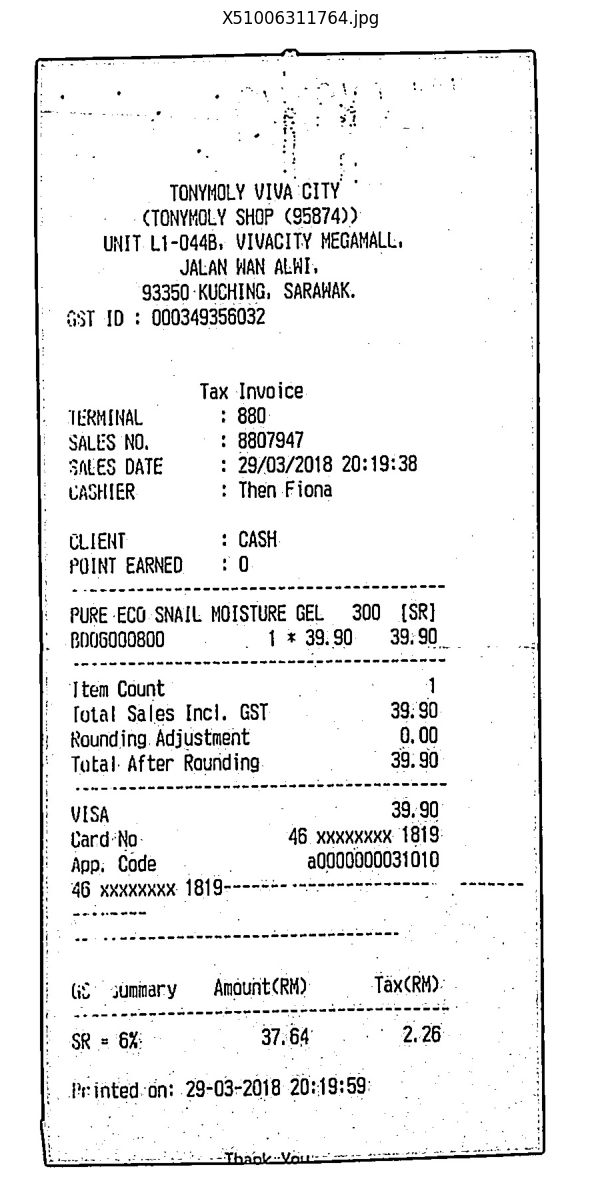

Extracted info for the receipt:
 {'company': 'TONYMOLY VIVA CITY', 'date': '29/03/2018', 'address': 'UNIT L1-044B, VIVACITY MEGAMALL, JALAN WAN ALWI, 93350-KUCHING, SARAWAK.', 'total': '39.90'}



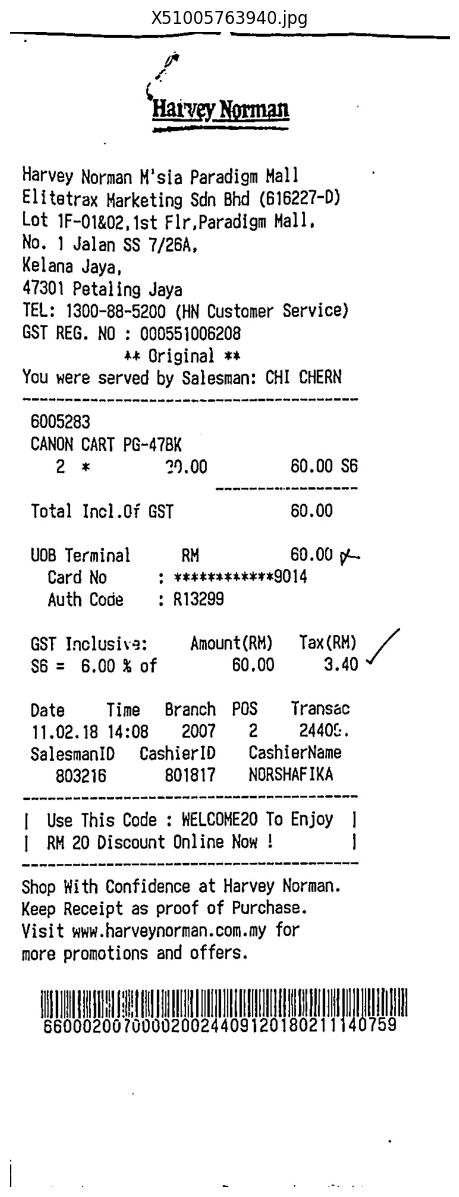

Extracted info for the receipt:
 {'company': 'Harvey Norman', 'date': '11.02.18', 'address': 'Lot 1F-01&02,1st Flr,Paradigm Mall, No. 1 Jalan SS 7/26A, Kelana Jaya, 47301 Petaling Jaya', 'total': '60.00'}



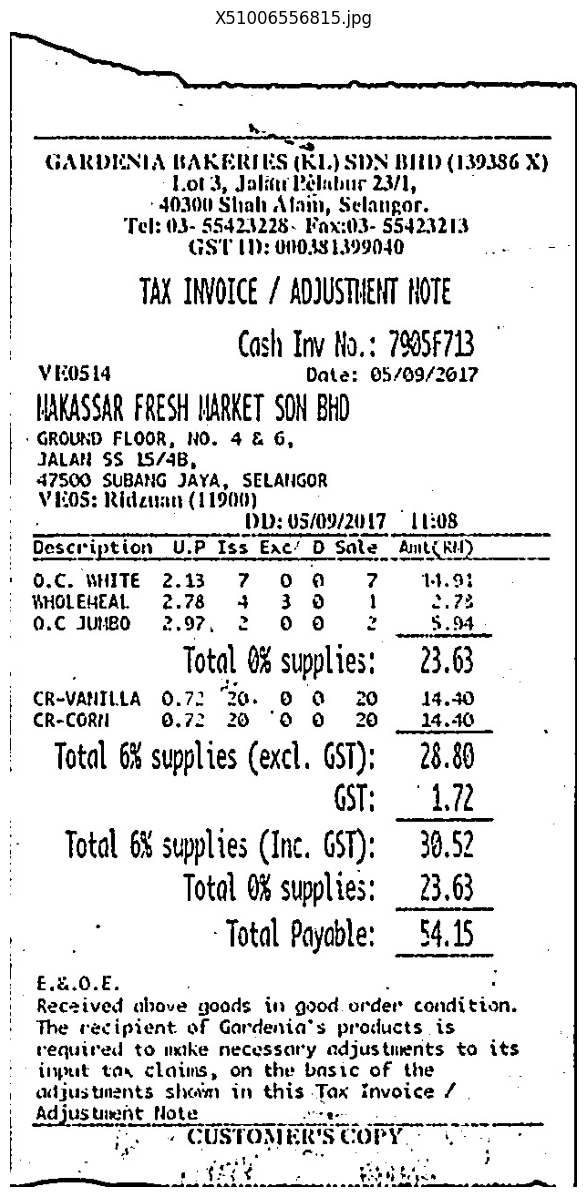

Extracted info for the receipt:
 {'company': 'GARDENIA BAKERIES (KL.) SDN BHD', 'date': '05/09/2017', 'address': 'Lot 3, Jalan Pelabur 23/1, 40300 Shah Alam, Selangor.', 'total': '54.15'}



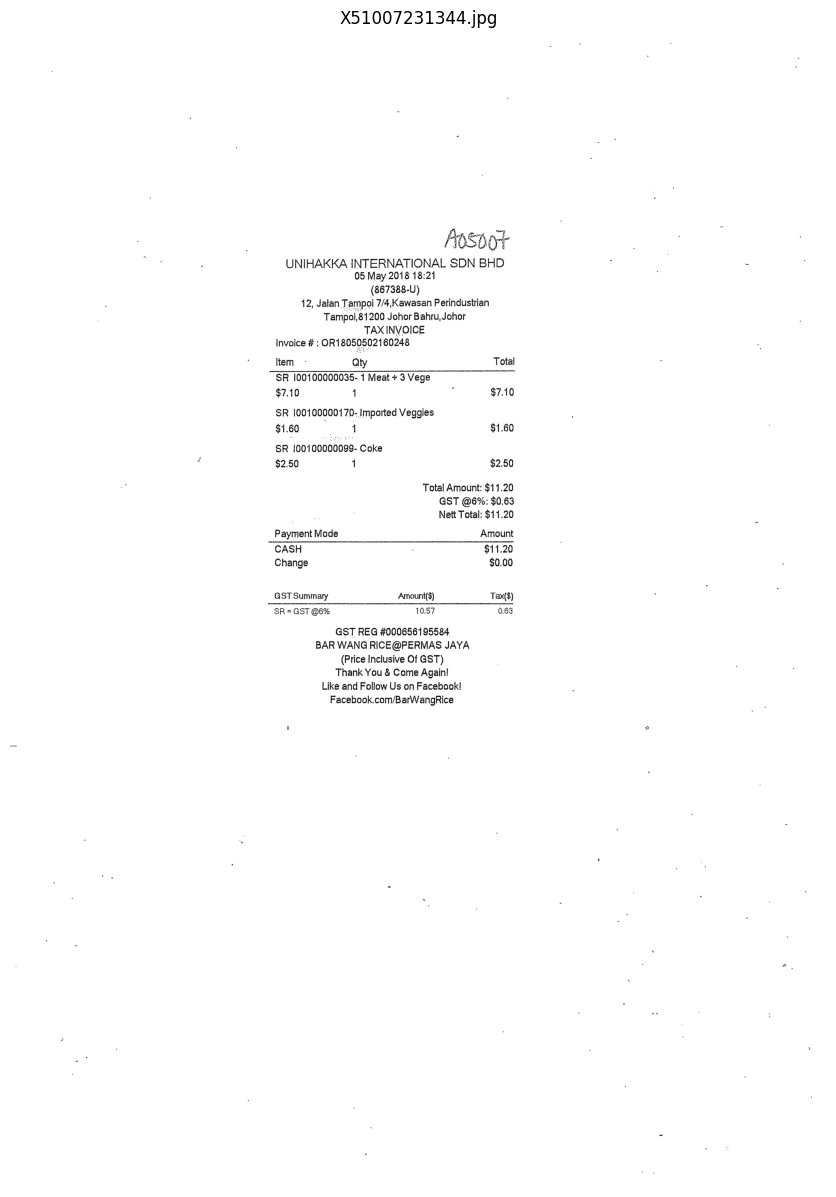

Extracted info for the receipt:
 {'company': 'UNIHAKKA INTERNATIONAL SDN BHD', 'date': '05 May 2018', 'address': '12, Jalan Tampoi 7/4, Kawasan Perindustrian Tampoi, 81200 Johor Bahru, Johor', 'total': '11.20'}



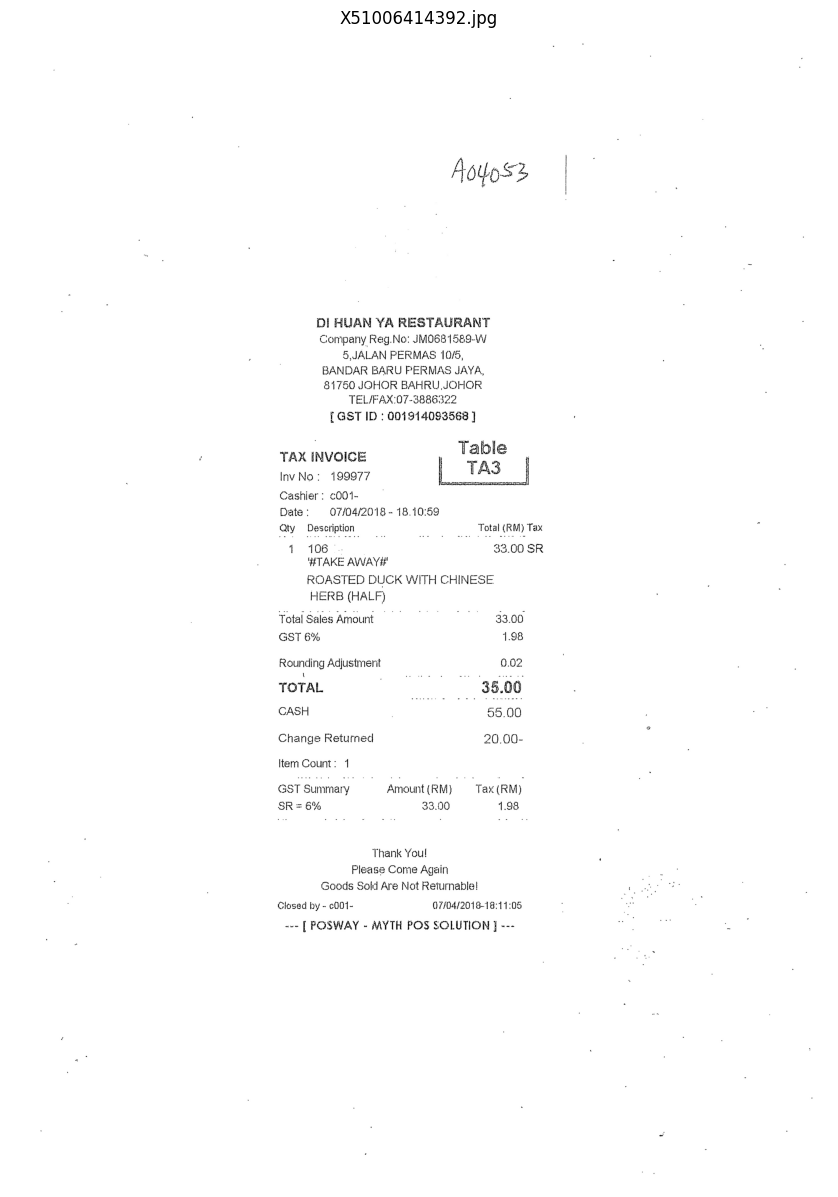

Extracted info for the receipt:
 {'company': 'DI HUAN YA RESTAURANT', 'date': '07/04/2018', 'address': '5, JALAN PERMAS 10/5, BANDAR BARU PERMAS JAYA, 81750 JOHOR BAHRU, JOHOR', 'total': '35.00'}



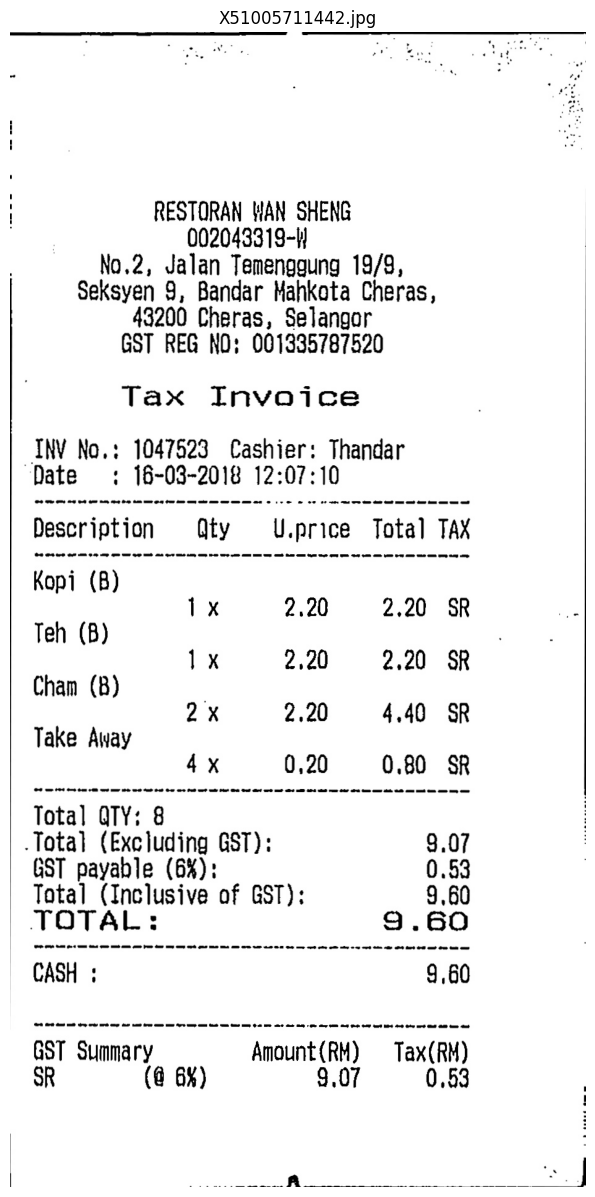

Extracted info for the receipt:
 {'company': 'RESTORAN WAN SHENG', 'date': '16-03-2018', 'address': 'No.2, Jalan Temenggung 19/9, Seksyen 9, Bandar Mahkota Cheras, 43200 Cheras, Selangor', 'total': '9.60'}



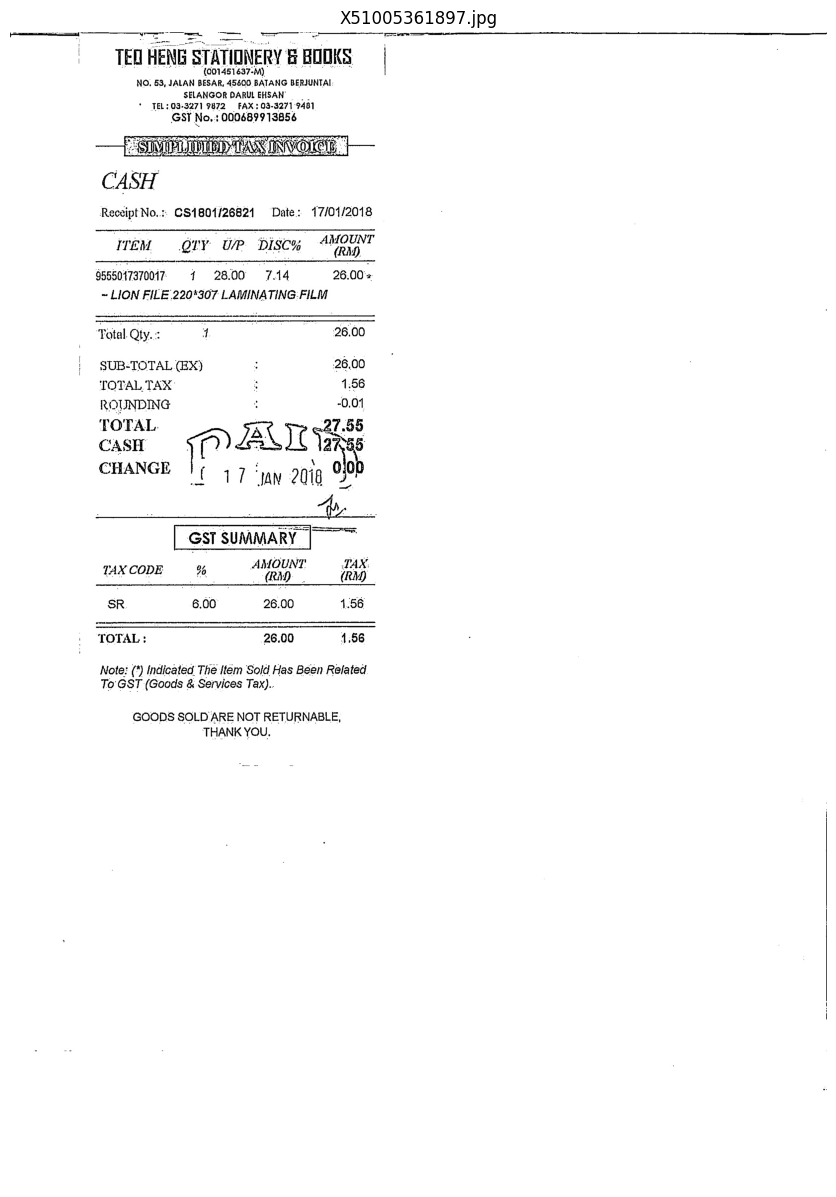

Extracted info for the receipt:
 {'company': 'TEO HENG STATIONERY & BOOKS', 'date': '17/01/2018', 'address': 'NO. 53, JALAN BESAR, 45800 BATANG BERJUNTAI, SELANGOR DARUL EHSAN', 'total': '27.55'}



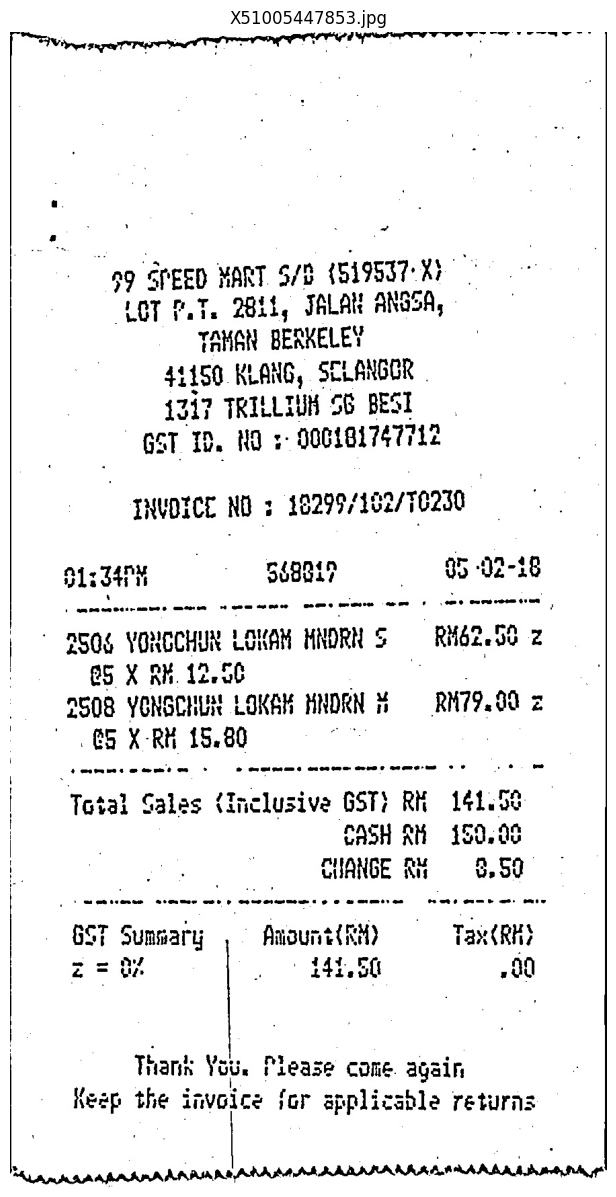

Extracted info for the receipt:
 {'company': '99 SPEED MART S/B', 'date': '05-02-2018', 'address': 'LOT P.T. 2811, JALAN ANGGSA, TAMAN BERKELEY, 41150 KLANG, SELANGOR, 1317 TRILLIUM SG BESI', 'total': '141.50'}



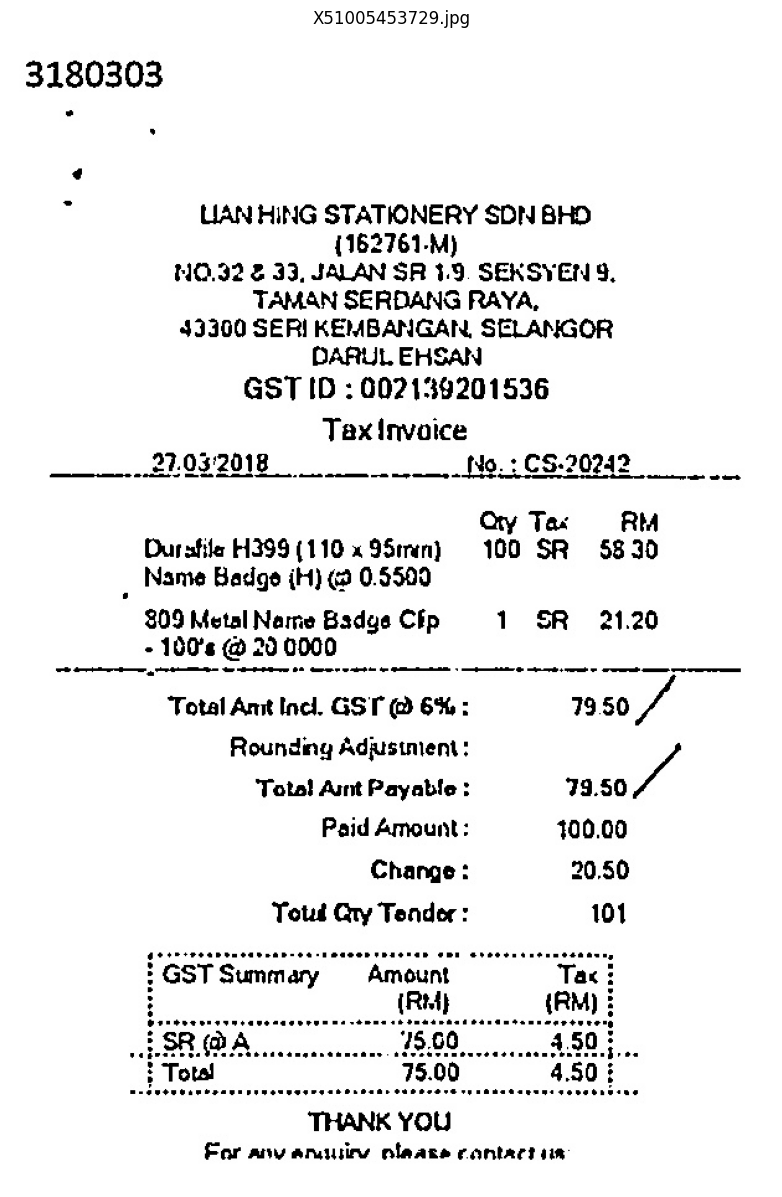

Extracted info for the receipt:
 {'company': 'LIAN HING STATIONERY SDN BHD', 'date': '27/03/2018', 'address': 'NO.32 & 33, JALAN SR 1.9. SEKSYEN 9.\nTAMAN SERDANG RAYA,\n43300 SERI KEMBANGAN, SELANGOR\nDARUL EHSAN', 'total': '79.50'}



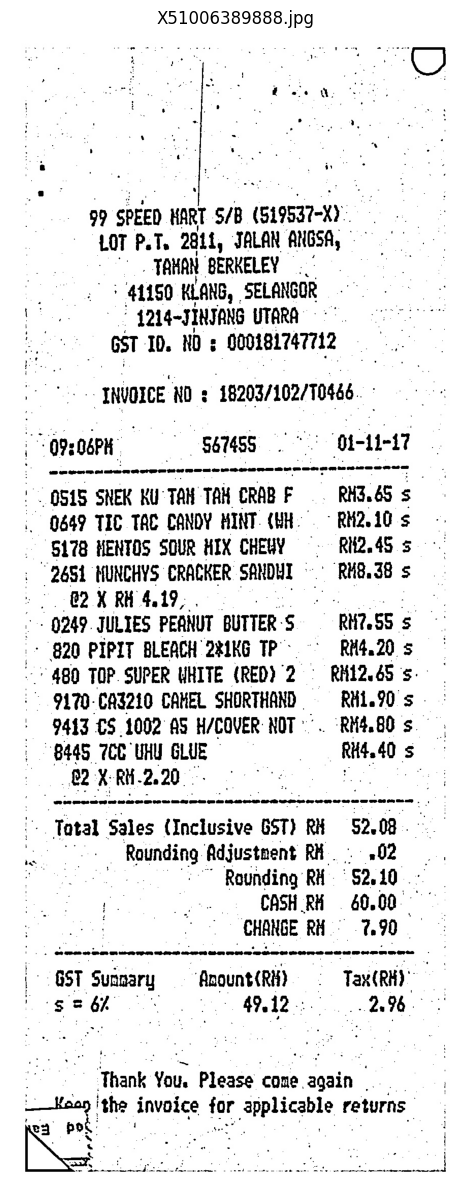

Extracted info for the receipt:
 {'company': '99 SPEED MART S/B', 'date': '01-11-17', 'address': 'LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY, 41150 KLANG, SELANGOR, 1214-JINJANG UTARA', 'total': '52.08'}



In [159]:
image_folder_path = "/content/processed_images"
json_folder_path = "/content/json_output/"

for image_name in os.listdir(image_folder_path):
    image_path = os.path.join(image_folder_path, image_name)

    img = cv.imread(image_path)

    # img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    # Ensure numeric type
    img = img.astype('uint8')

    with open(json_folder_path + image_name.replace('.jpg', '.json'), "r") as f:
      data = json.load(f)

    # Display
    plt.figure(figsize=(15, 15))
    plt.imshow(img)
    plt.title(image_name)
    plt.axis('off')
    plt.show()
    print(f"Extracted info for the receipt:\n {data}", end='\n\n')
